In [1]:
import os
import glob
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom

In [2]:
# read data
INPUT_DIR = 'rsna-2024-lumbar-spine-degenerative-classification'

train = pl.read_csv(f'{INPUT_DIR}/train.csv')
print(train.head())
train_label = pl.read_csv(f'{INPUT_DIR}/train_label_coordinates.csv')
print(train_label[1])
train_desc = pl.read_csv(f'{INPUT_DIR}/train_series_descriptions.csv')
print(train_desc)

shape: (5, 26)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ study_id ┆ spinal_ca ┆ spinal_ca ┆ spinal_ca ┆ … ┆ right_sub ┆ right_sub ┆ right_sub ┆ right_sub │
│ ---      ┆ nal_steno ┆ nal_steno ┆ nal_steno ┆   ┆ articular ┆ articular ┆ articular ┆ articular │
│ i64      ┆ sis_l1_l2 ┆ sis_l2_l3 ┆ sis_l3_l4 ┆   ┆ _stenosis ┆ _stenosis ┆ _stenosis ┆ _stenosis │
│          ┆ ---       ┆ ---       ┆ ---       ┆   ┆ _l2…      ┆ _l3…      ┆ _l4…      ┆ _l5…      │
│          ┆ str       ┆ str       ┆ str       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│          ┆           ┆           ┆           ┆   ┆ str       ┆ str       ┆ str       ┆ str       │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 4003253  ┆ Normal/Mi ┆ Normal/Mi ┆ Normal/Mi ┆ … ┆ Normal/Mi ┆ Normal/Mi ┆ Normal/Mi ┆ Normal/Mi │
│          ┆ ld        ┆ ld        ┆ ld        ┆   ┆ ld        ┆ ld        ┆

shape: (1, 3)
┌────────────┬────────────┬──────────┐
│ column_0   ┆ column_1   ┆ column_2 │
│ ---        ┆ ---        ┆ ---      │
│ i64        ┆ i64        ┆ i64      │
╞════════════╪════════════╪══════════╡
│ 4290709089 ┆ 3274612423 ┆ 9        │
└────────────┴────────────┴──────────┘
shape: (1, 3)
┌────────────┬────────────┬──────────┐
│ column_0   ┆ column_1   ┆ column_2 │
│ ---        ┆ ---        ┆ ---      │
│ i64        ┆ i64        ┆ i64      │
╞════════════╪════════════╪══════════╡
│ 4290709089 ┆ 3274612423 ┆ 9        │
└────────────┴────────────┴──────────┘
shape: (1, 3)
┌────────────┬────────────┬──────────┐
│ column_0   ┆ column_1   ┆ column_2 │
│ ---        ┆ ---        ┆ ---      │
│ i64        ┆ i64        ┆ i64      │
╞════════════╪════════════╪══════════╡
│ 4290709089 ┆ 3274612423 ┆ 9        │
└────────────┴────────────┴──────────┘
shape: (1, 3)
┌────────────┬────────────┬──────────┐
│ column_0   ┆ column_1   ┆ column_2 │
│ ---        ┆ ---        ┆ ---      │
│ i64   

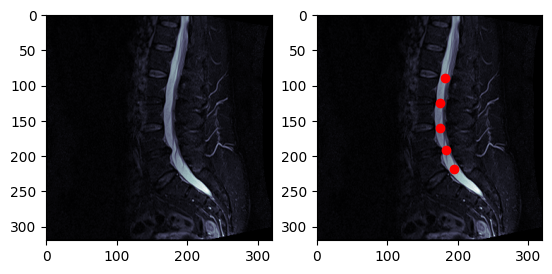

In [3]:
def graph_plot(study_id, series_id):
    train_label_combinations = pl.DataFrame()
    for row in train_label.iter_rows():
        if row[0]==study_id:
            print(pl.DataFrame(row[:3]).transpose())
            data = pl.DataFrame(row[:3]).transpose()
            train_label_combinations=pl.concat([train_label_combinations, data])
    print(train_label_combinations)
    
    #rename columns
    train_label_combinations = train_label_combinations.rename({"column_0":"study_id", "column_1":"series_id", "column_2":"instance_number"})
    #extract unique combination
    train_label_combinations = train_label_combinations.unique(subset=["study_id", "series_id", "instance_number"]).sort(["study_id", "series_id", "instance_number"])
    
    instance_number_list = train_label_combinations.filter((pl.col("study_id")==study_id) & (pl.col("series_id")==series_id)).get_column("instance_number")
    #instance_number_list

    for instance_number in instance_number_list:
        #print(instance_number)
        print(f"=====study_id:{study_id}, series_id:{series_id}, instance_number:{instance_number}=====")
        #read image
        ds = pydicom.read_file(f'{INPUT_DIR}/train_images/{study_id}/{series_id}/{instance_number}.dcm')
        #draw original image
        df_plt = train_label.filter(
            (pl.col('study_id')==study_id)
            &(pl.col('series_id')==series_id)
            &(pl.col('instance_number')==instance_number)
        )
        plt.subplot(1,2,1)
        plt.imshow(ds.pixel_array, cmap='bone')
        #plt.title(f"study_id:{study_id}, series_id:{series_id}, instance_number:{instance_number}")

        #draw original image + label
        #draw image
        df_plt = train_label.filter(
            (pl.col('study_id')==study_id)
            &(pl.col('series_id')==series_id)
            &(pl.col('instance_number')==instance_number)
        )
        plt.subplot(1,2,2)
        plt.imshow(ds.pixel_array, cmap='bone')
        #plt.title(f"study_id:{study_id}, series_id:{series_id}, instance_number:{instance_number}")
        #draw rabel
        for row in df_plt.iter_rows():
            plt.scatter(row[-2], row[-1], color='red')
        plt.show()

study_id, series_id = 4290709089, 3274612423
graph_plot(study_id, series_id)

# Visualize the pixel array

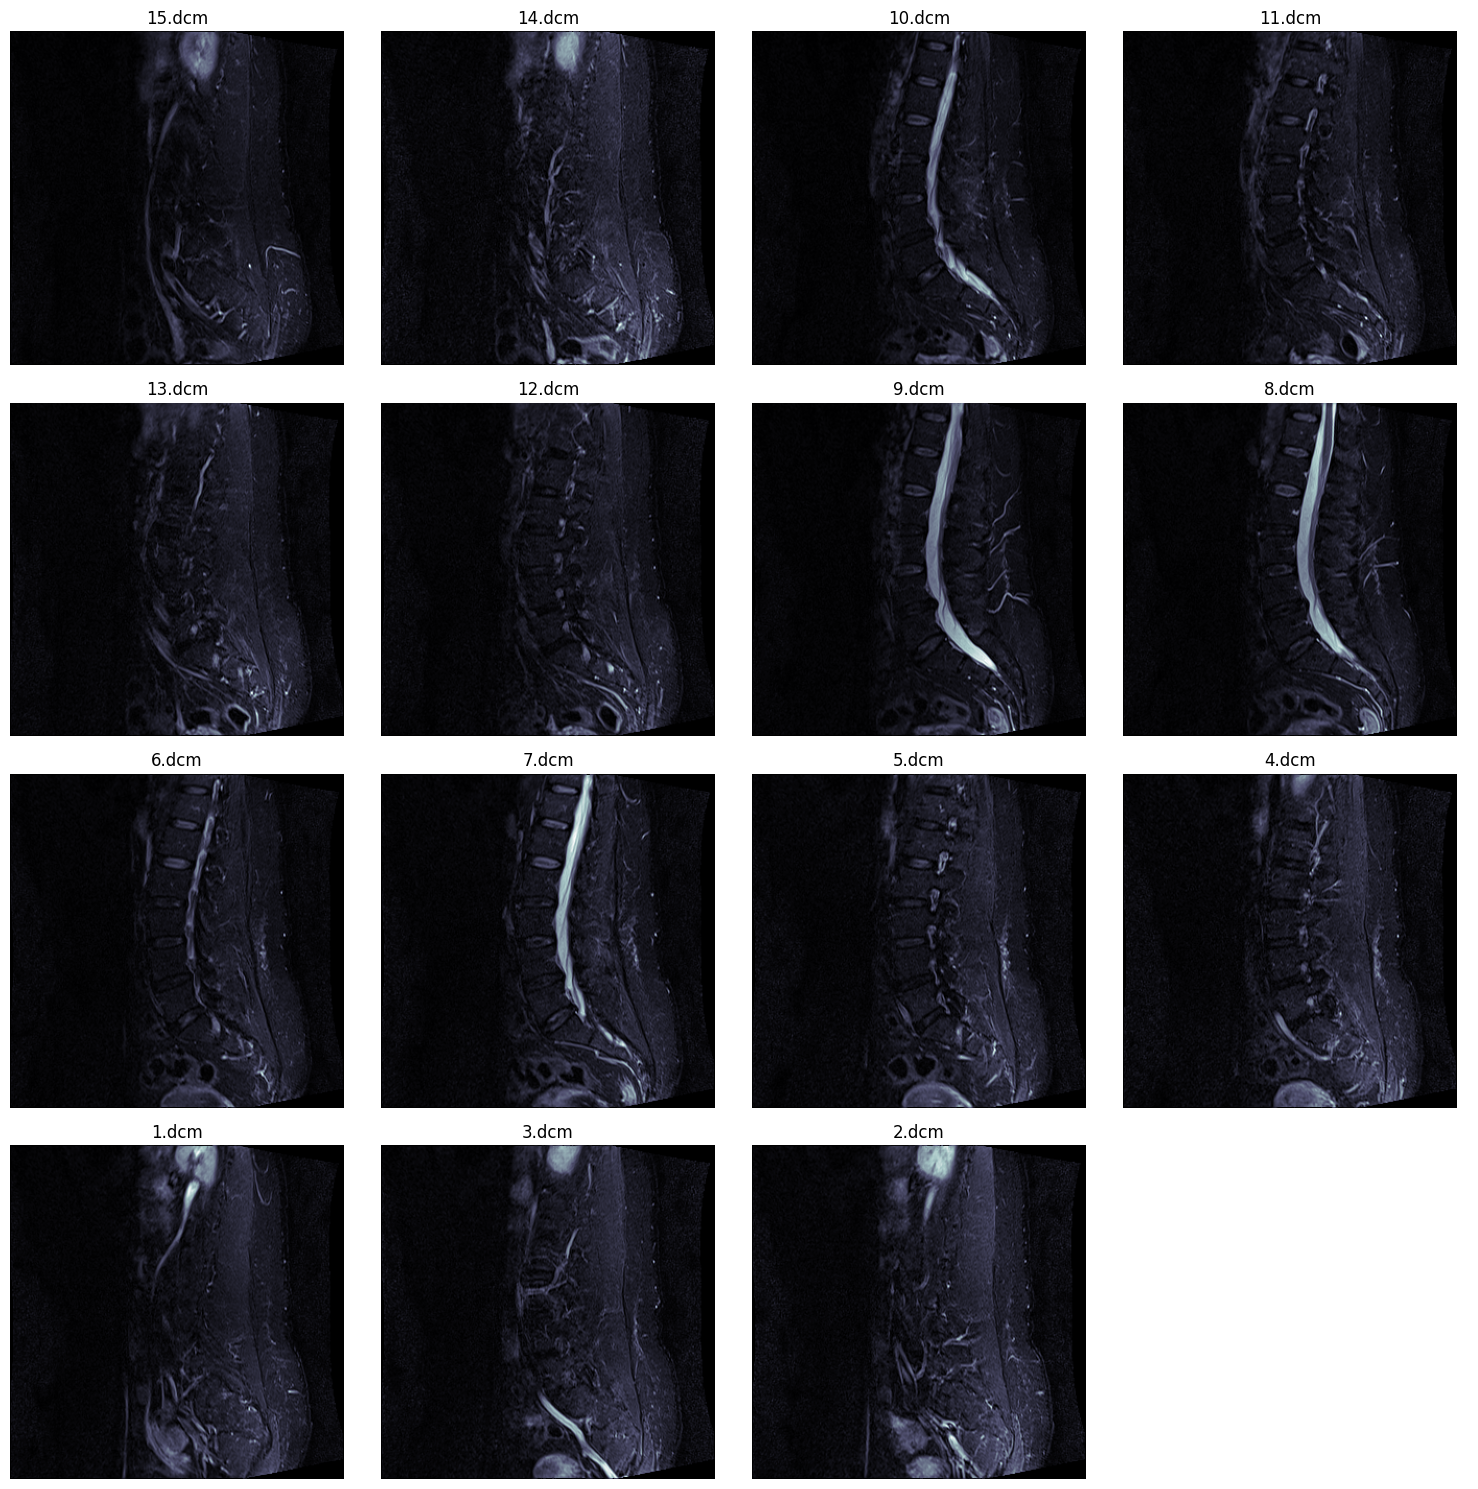

In [4]:
from PIL import Image

def visualizeImage(directory):
    images = [f for f in os.listdir(directory) if f.endswith('.dcm')]

    # Number of images
    grid_size = len(images)

    grid_size = int(grid_size ** 0.5) + 1

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15,15))

    axes = axes.flatten()

    for idx, file in enumerate(images):
        ds = pydicom.read_file(os.path.join(directory, file))
        axes[idx].imshow(ds.pixel_array, cmap='bone')
        axes[idx].set_title(file)
        axes[idx].axis('off')

    # Hide any remaining empty subplots
    for i in range(idx + 1, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show

directory =f'{INPUT_DIR}/train_images/{study_id}/{series_id}'
visualizeImage(directory)


In [5]:
def list_of_picture(directory):
    all_the_pic = []
    # path_dir = os.path.join(direc)

    for i in os.listdir(directory):
        all_the_pic.append(i)
    return all_the_pic

path_dir = f'{INPUT_DIR}/train_images/{study_id}/{series_id}'
list_of_picture(path_dir)

['15.dcm',
 '14.dcm',
 '10.dcm',
 '11.dcm',
 '13.dcm',
 '12.dcm',
 '9.dcm',
 '8.dcm',
 '6.dcm',
 '7.dcm',
 '5.dcm',
 '4.dcm',
 '1.dcm',
 '3.dcm',
 '2.dcm']

# Check for missing data

In [6]:
data = pd.read_csv("rsna-2024-lumbar-spine-degenerative-classification/train.csv")
missing_values_count = pd.isnull(data).sum()
print(missing_values_count)

study_id                                    0
spinal_canal_stenosis_l1_l2                 1
spinal_canal_stenosis_l2_l3                 1
spinal_canal_stenosis_l3_l4                 1
spinal_canal_stenosis_l4_l5                 1
spinal_canal_stenosis_l5_s1                 1
left_neural_foraminal_narrowing_l1_l2       2
left_neural_foraminal_narrowing_l2_l3       2
left_neural_foraminal_narrowing_l3_l4       2
left_neural_foraminal_narrowing_l4_l5       2
left_neural_foraminal_narrowing_l5_s1       2
right_neural_foraminal_narrowing_l1_l2      8
right_neural_foraminal_narrowing_l2_l3      8
right_neural_foraminal_narrowing_l3_l4      8
right_neural_foraminal_narrowing_l4_l5      8
right_neural_foraminal_narrowing_l5_s1      8
left_subarticular_stenosis_l1_l2          164
left_subarticular_stenosis_l2_l3           82
left_subarticular_stenosis_l3_l4            3
left_subarticular_stenosis_l4_l5            3
left_subarticular_stenosis_l5_s1           11
right_subarticular_stenosis_l1_l2 

# Checking the distribution of train dataset

In [7]:
df = pd.read_csv(f"{INPUT_DIR}/train.csv")

# Function for melting columns
def melting_columns(df):
    df_melted = pd.melt(df, 
                            id_vars=['study_id'], 
                            value_vars=[
                                'spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4', 
                                'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1', 'left_neural_foraminal_narrowing_l1_l2', 
                                'left_neural_foraminal_narrowing_l2_l3', 'left_neural_foraminal_narrowing_l3_l4', 
                                'left_neural_foraminal_narrowing_l4_l5', 'left_neural_foraminal_narrowing_l5_s1', 
                                'right_neural_foraminal_narrowing_l1_l2', 'right_neural_foraminal_narrowing_l2_l3', 
                                'right_neural_foraminal_narrowing_l3_l4', 'right_neural_foraminal_narrowing_l4_l5', 
                                'right_neural_foraminal_narrowing_l5_s1', 'left_subarticular_stenosis_l1_l2', 
                                'left_subarticular_stenosis_l2_l3', 'left_subarticular_stenosis_l3_l4', 
                                'left_subarticular_stenosis_l4_l5', 'left_subarticular_stenosis_l5_s1', 
                                'right_subarticular_stenosis_l1_l2', 'right_subarticular_stenosis_l2_l3', 
                                'right_subarticular_stenosis_l3_l4', 'right_subarticular_stenosis_l4_l5', 
                                'right_subarticular_stenosis_l5_s1'
                            ], 
                            var_name='condition', 
                            value_name='severity')
    return df_melted

# Visualize the distribution
def distribution_graph(ax, df, title):
    df_melted = melting_columns(df) #From avobe functions

    print(df_melted.head())
    print(len(df_melted))

    # Check the distribution of severity levels
    severity_counts = df_melted['severity'].value_counts()
    print(severity_counts)

    # Plot pie chart
    ax.pie(severity_counts, 
           labels=severity_counts.index, 
           autopct='%1.1f%%', 
           startangle=90, 
           colors=plt.get_cmap('Set2').colors)
    ax.set_title(title)
    



# Percentage of distribution each severity on Original Data

   study_id                    condition     severity
0   4003253  spinal_canal_stenosis_l1_l2  Normal/Mild
1   4646740  spinal_canal_stenosis_l1_l2  Normal/Mild
2   7143189  spinal_canal_stenosis_l1_l2  Normal/Mild
3   8785691  spinal_canal_stenosis_l1_l2  Normal/Mild
4  10728036  spinal_canal_stenosis_l1_l2  Normal/Mild
49375
severity
Normal/Mild    37754
Moderate        7960
Severe          3089
Name: count, dtype: int64


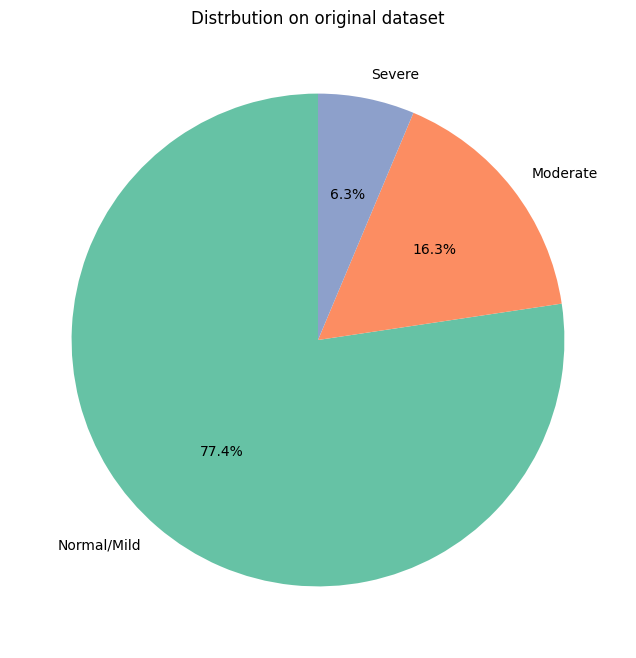

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

distribution_graph(ax, df, "Distrbution on original dataset")

# Impute data as most recent value using Skit Learn on train.csv

In [9]:
from sklearn.impute import SimpleImputer

df_copy = df.copy()

categorical_columns = df_copy.select_dtypes(include=['object']).columns

categorical_imputer = SimpleImputer(strategy='most_frequent')
df_copy[categorical_columns] = categorical_imputer.fit_transform(df_copy[categorical_columns])

# Checking missing data again
print(df_copy.isnull().sum())


df_melted_copy = melting_columns(df_copy)


study_id                                  0
spinal_canal_stenosis_l1_l2               0
spinal_canal_stenosis_l2_l3               0
spinal_canal_stenosis_l3_l4               0
spinal_canal_stenosis_l4_l5               0
spinal_canal_stenosis_l5_s1               0
left_neural_foraminal_narrowing_l1_l2     0
left_neural_foraminal_narrowing_l2_l3     0
left_neural_foraminal_narrowing_l3_l4     0
left_neural_foraminal_narrowing_l4_l5     0
left_neural_foraminal_narrowing_l5_s1     0
right_neural_foraminal_narrowing_l1_l2    0
right_neural_foraminal_narrowing_l2_l3    0
right_neural_foraminal_narrowing_l3_l4    0
right_neural_foraminal_narrowing_l4_l5    0
right_neural_foraminal_narrowing_l5_s1    0
left_subarticular_stenosis_l1_l2          0
left_subarticular_stenosis_l2_l3          0
left_subarticular_stenosis_l3_l4          0
left_subarticular_stenosis_l4_l5          0
left_subarticular_stenosis_l5_s1          0
right_subarticular_stenosis_l1_l2         0
right_subarticular_stenosis_l2_l

# Compare the before and after imputation

   study_id                    condition     severity
0   4003253  spinal_canal_stenosis_l1_l2  Normal/Mild
1   4646740  spinal_canal_stenosis_l1_l2  Normal/Mild
2   7143189  spinal_canal_stenosis_l1_l2  Normal/Mild
3   8785691  spinal_canal_stenosis_l1_l2  Normal/Mild
4  10728036  spinal_canal_stenosis_l1_l2  Normal/Mild
49375
severity
Normal/Mild    37754
Moderate        7960
Severe          3089
Name: count, dtype: int64
   study_id                    condition     severity
0   4003253  spinal_canal_stenosis_l1_l2  Normal/Mild
1   4646740  spinal_canal_stenosis_l1_l2  Normal/Mild
2   7143189  spinal_canal_stenosis_l1_l2  Normal/Mild
3   8785691  spinal_canal_stenosis_l1_l2  Normal/Mild
4  10728036  spinal_canal_stenosis_l1_l2  Normal/Mild
49375
severity
Normal/Mild    38326
Moderate        7960
Severe          3089
Name: count, dtype: int64


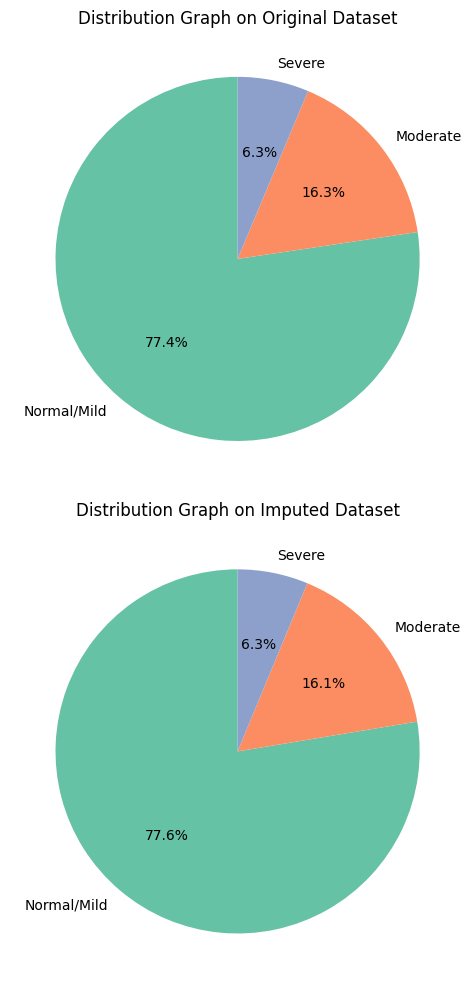

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10))

distribution_graph(axes[0], df, "Distribution Graph on Original Dataset")
distribution_graph(axes[1], df_copy, "Distribution Graph on Imputed Dataset")

# Display the plots
plt.tight_layout()
plt.show()

# Creating Custom Dataset from given image data and coordinates

In [13]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def structure_for_train_csv(condition):
        condition = condition.lower().replace(' ', '_').replace('/', '_')
        return condition

class SpinalDataset(Dataset):
    def __init__(self, root_dir, coordinates_file, train, train_data, transform=None):
        self.root_dir = root_dir
        self.coordinates = pd.read_csv(coordinates_file)
        self.train_data = pd.read_csv(train_data)
        self.train = train
        self.transform = transform

        # Perform imputation on the training data
        self.train_data = self.impute_missing_values(self.train_data)

        # Define label encoder and one hot encoder
        self.label_encoder = LabelEncoder()
        self.onehot_encoder = OneHotEncoder(sparse_output=False)

        # Fit the label encoder and one hot encoder
        conditions = ["Normal/Mild", "Moderate", "Severe"]

        self.label_encoder.fit(conditions)
        integer_encoded = self.label_encoder.transform(conditions).reshape(-1, 1)
        self.onehot_encoder.fit(integer_encoded)

        # Define sample weights
        self.weights = {"Normal/Mild": 1, "Moderate": 2, "Severe": 4}

        # Define a transformation pipeline for resizing and converting to tensor
        self.image_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((512, 512)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.coordinates)
    
    def __getitem__(self, idx):
        row = self.coordinates.iloc[idx]
        study_id = row['study_id']
        series_id = row['series_id']
        instance = row['instance_number']
        condition = row['condition']
        level = row['level']
        x = row['x']
        y = row['y'] 

        # Construct the path to the DICOM
        dicom_file_path = os.path.join(self.root_dir, self.train, str(study_id), str(series_id), f"{instance}.dcm")
        
        # Load and process the DICOM image
        image, original_height, original_width = self.load_dicom_image(dicom_file_path)

        # Calculate scaling factors
        x_scale = 512 / original_width
        y_scale = 512 / original_height

        # Adjust the coordinates based on the scaling
        adjusted_x = x * x_scale
        adjusted_y = y * y_scale

        # Resize and convert the image to a tensor
        image = self.image_transform(image)

        # Extract condition for the specified level
        condition_column = f'{condition}_{level}'
        condition_column = structure_for_train_csv(condition_column)
        label_str = self.train_data.loc[self.train_data['study_id'] == study_id, condition_column].values[0]

        # Encode the label
        label_encoded = self.label_encoder.transform([label_str])
        label_onehot = self.onehot_encoder.transform(label_encoded.reshape(-1, 1))
        label = torch.tensor(label_onehot, dtype=torch.float32).squeeze()

        # Calculate weight for the sample
        weight = self.weights.get(label_str, 1)  # Default to 1 if condition not found

        return image, label, weight, adjusted_x, adjusted_y
    
    def load_dicom_image(self, file_path):
        dicom = pydicom.dcmread(file_path)
        image = dicom.pixel_array
        
        # Normalize the pixel values to [0, 1]
        image = image.astype(np.float32) / image.max()

        # Get original dimensions
        original_height, original_width = image.shape

        return image, original_height, original_width

    def impute_missing_values(self, df):
        # Select categorical columns for imputation
        categorical_columns = df.select_dtypes(include=['object']).columns

        # Initialize the SimpleImputer for categorical columns
        categorical_imputer = SimpleImputer(strategy='most_frequent')

        # Fit and transform the categorical columns
        df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

        return df

from torch.utils.data import DataLoader

# Example usage
dataset = SpinalDataset(root_dir=INPUT_DIR, 
                        coordinates_file=f'{INPUT_DIR}/train_label_coordinates.csv', 
                        train='train_images',
                        train_data=f'{INPUT_DIR}/train.csv')

dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

for images, labels, weights, x, y in dataloader:
    print("Images shape:", images.shape)
    print("Labels:", labels)
    print("Weights:", weights)
    print(f"x: {x}")
    print(f"y: {y}")

Images shape: torch.Size([5, 1, 512, 512])
Labels: tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.]])
Weights: tensor([1, 1, 1, 2, 1])
x: tensor([247.0385, 285.2711, 239.8684, 228.0938, 224.5963], dtype=torch.float64)
y: tensor([282.5858, 264.1350, 273.6842, 265.8626, 234.1307], dtype=torch.float64)
Images shape: torch.Size([5, 1, 512, 512])
Labels: tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
Weights: tensor([1, 4, 1, 1, 4])
x: tensor([276.9929, 258.1219, 219.3183, 264.5487, 270.3058], dtype=torch.float64)
y: tensor([256.0000, 260.2187, 244.4163, 353.7329, 273.6586], dtype=torch.float64)
Images shape: torch.Size([5, 1, 512, 512])
Labels: tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])
Weights: tensor([1, 4, 1, 1, 1])
x: tensor([333.4490, 214.4854, 289.2598, 247.6389, 282.8387], dtype=torch.float64)


KeyboardInterrupt: 

In [ ]:
def visualize_image_and_heatmap(image, heatmap):
    image = image.squeeze().permute(1, 2, 0).numpy()  # Convert to HWC format
    heatmap = np.squeeze(heatmap)  # Remove any extra dimensions

    # Plot the image and heatmap
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    ax[1].imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    ax[1].set_title('Heatmap')
    ax[1].axis('off')
    
    plt.show()



# Train